<a href="https://colab.research.google.com/github/AthanasiosTh/Anomaly_Detection.ipynb/blob/main/Lambda_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y

In [4]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [6]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

In [7]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

In [8]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [9]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

In [10]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])

Epoch 1/5
188/188 [==============================] - 2s 4ms/step - loss: 0.6463 - accuracy: 0.7514
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4826 - accuracy: 0.8553
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4514 - accuracy: 0.8767
Epoch 4/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4191 - accuracy: 0.8858
Epoch 5/5
94/94 [==============================] - 0s 2ms/step
Batch 800, Training Accuracy: 0.9136, Test Accuracy: 0.9008
Epoch 1/5
188/188 [==============================] - 2s 4ms/step - loss: 0.6379 - accuracy: 0.7599
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4753 - accuracy: 0.8596
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4407 - accuracy: 0.8749
Epoch 4/5
188/188 [==============================] - 1s 4ms/step - loss: 0.4169 - accuracy: 0.8875
Epoch 5/5
94/94 [==============================] - 0s 2ms/step
Batch 1600, Training A

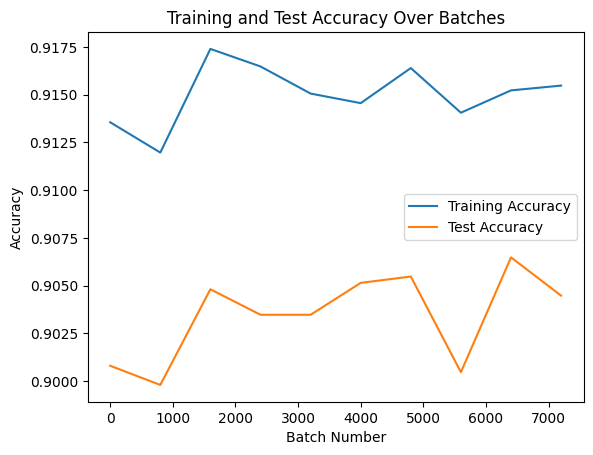

In [11]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)